In [5]:
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [6]:
# First, install the library using pip
!pip install split-folders

# Then, import the library
import splitfolders

# Specify the path to your dataset and the output directory
input_folder = 'C:\\Users\\jalad\\Downloads\\Healthy-Defective-Fruits-main\\Healthy-Defective-Fruits-main\\mango_images\\mango_real_images'
output_folder = 'C:\\Users\\jalad\\Downloads\\Healthy-Defective-Fruits-main\\Healthy-Defective-Fruits-main\\mango_images\\output file'

# Use the ratio function to split the data
# This will split the dataset into training and test sets with 80% and 20% of the data respectively
splitfolders.ratio(input_folder, output=output_folder, seed=1337, ratio=(.8, .2))


Copying files: 5000 files [00:02, 2457.82 files/s]


In [7]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)
training_set = train_datagen.flow_from_directory('C:\\Users\\jalad\\Downloads\\Healthy-Defective-Fruits-main\\Healthy-Defective-Fruits-main\\mango_images\\output file\\train',
                                                 target_size=(64,64),
                                                 batch_size=32,
                                                 class_mode='sparse')

Found 4000 images belonging to 4 classes.


In [8]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_set = test_datagen.flow_from_directory('C:\\Users\\jalad\\Downloads\\Healthy-Defective-Fruits-main\\Healthy-Defective-Fruits-main\\mango_images\\output file\\val',
                                                 target_size=(64,64),
                                                 batch_size=32,
                                                 class_mode='sparse')

Found 1000 images belonging to 4 classes.


In [9]:
from tensorflow import keras

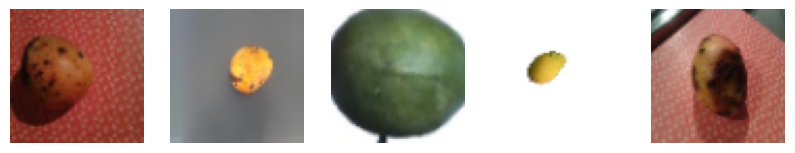

In [10]:
import matplotlib.pyplot as plt
# Get a batch of images
images, labels = next(training_set)

# Define number of images to show
num_images = 5

# Plot the images
plt.figure(figsize=(10, 10))
for i in range(num_images):
    plt.subplot(1, num_images, i+1)
    plt.imshow(images[i])
    plt.axis('off')
plt.show()


In [7]:
#Hyperparameter tuning to get best parameters
def build_model(hp):
  model = keras.Sequential()
  #Constructing a common architecture of CNN
  model.add(keras.layers.Conv2D(filters = hp.Int('conv_1_filters',min_value=16, max_value = 128, step = 16),
                                kernel_size=hp.Choice('kernel1_size',values=[3,5,7]),
                                input_shape=(64,64,3),
                                activation='relu',groups=1))
  model.add(keras.layers.MaxPool2D(pool_size = hp.Int('pool_1_size',min_value=2,max_value=8,step=1),
                                   strides=hp.Choice('strides_1',values=[1,2,3])))


  model.add(keras.layers.Conv2D(filters = hp.Int('conv_2_filters',min_value=16, max_value = 128, step = 16),
                                kernel_size=hp.Choice('kernel2_size',values=[3,5,7]),
                                activation='relu',groups=1))
  model.add(keras.layers.MaxPool2D(pool_size = hp.Int('pool_2_size',min_value=2,max_value=8,step=1),
                                   strides=hp.Choice('strides_2',values=[1,2,3])))

  model.add(keras.layers.Flatten())


  model.add(keras.layers.Dense(units=hp.Int('dense_1_layer',min_value=16,max_value=256,step=16),
                               activation='relu'))
  model.add(keras.layers.Dense(units=9,activation='softmax'))

  model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate',values=[1e-2,1e-3])),
                                                loss='sparse_categorical_crossentropy',
                                                metrics=['accuracy'])
  return model

In [8]:
!pip install keras-tuner
from kerastuner import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters

tunersearch = RandomSearch(build_model,objective='val_accuracy',max_consecutive_failed_trials=3,
                           max_trials=5,directory='output',project_name='Mangoes_')

tunersearch.search(training_set,
                   epochs=7,
                   validation_data=test_set)

Trial 5 Complete [00h 01m 37s]
val_accuracy: 0.9980000257492065

Best val_accuracy So Far: 0.9980000257492065
Total elapsed time: 00h 24m 32s


In [9]:
model = tunersearch.get_best_models(num_models=1)[0]
model.summary()
# This is the model with best accuracy among the 5 trials.

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 58, 58, 32)        4736      
                                                                 
 max_pooling2d (MaxPooling2  (None, 27, 27, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 23, 23, 96)        76896     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 16, 16, 96)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 24576)             0         
                                                                 
 dense (Dense)               (None, 64)                1

In [10]:
#Since the accuracy in the previous model is very low, differet architecture of CNN is trained
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Dense,GlobalAveragePooling2D
from tensorflow.keras.models import Model

# Using vgg16 architecture

vgg = VGG16(input_shape=[224,224,3],weights = 'imagenet', include_top=False)

# Fixing vgg model layers to prevent them from losing the weights from pre-trained model
for i in vgg.layers:
  i.trainable = False
#Adding our own layers
x = GlobalAveragePooling2D()(vgg.output)
x = Dense(units = 500, activation='relu')(x)
x = Dense(units=4, activation='sigmoid')(x)
model2 = Model(inputs = vgg.input, outputs = x)
model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

#VGG16 expects input in [224,224,3] format
training_set = train_datagen.flow_from_directory('C:\\Users\\jalad\\Downloads\\Healthy-Defective-Fruits-main\\Healthy-Defective-Fruits-main\\mango_images\\output file\\train',
                                                target_size=(224,224),
                                                 batch_size=32,
                                                 class_mode='categorical')
test_set = test_datagen.flow_from_directory('C:\\Users\\jalad\\Downloads\\Healthy-Defective-Fruits-main\\Healthy-Defective-Fruits-main\\mango_images\\output file\\val',
                                                 target_size=(224,224),
                                                 batch_size=32,
                                                 class_mode='categorical')

model2.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy',keras.metrics.Precision(), keras.metrics.Recall()])
model2.fit(training_set,validation_data=test_set,epochs=7)

Found 4000 images belonging to 4 classes.
Found 1000 images belonging to 4 classes.
Epoch 1/7
125/125 [==============================] - 294s 2s/step - loss: 0.3745 - accuracy: 0.8792 - precision: 0.5530 - recall: 0.9605 - val_loss: 0.1111 - val_accuracy: 0.9740 - val_precision: 0.5952 - val_recall: 1.0000
Epoch 2/7
125/125 [==============================] - 302s 2s/step - loss: 0.1036 - accuracy: 0.9718 - precision: 0.6327 - recall: 0.9980 - val_loss: 0.0504 - val_accuracy: 0.9960 - val_precision: 0.6671 - val_recall: 1.0000
Epoch 3/7
125/125 [==============================] - 290s 2s/step - loss: 0.0539 - accuracy: 0.9858 - precision: 0.6913 - recall: 0.9998 - val_loss: 0.0263 - val_accuracy: 0.9970 - val_precision: 0.7321 - val_recall: 1.0000
Epoch 4/7
125/125 [==============================] - 286s 2s/step - loss: 0.0331 - accuracy: 0.9933 - precision: 0.7380 - recall: 1.0000 - val_loss: 0.0203 - val_accuracy: 0.9950 - val_precision: 0.7645 - val_recall: 1.0000
Epoch 5/7
125/125 [=

In [11]:
model2.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [12]:
model2.save('mangoes')

INFO:tensorflow:Assets written to: mangoes\assets


INFO:tensorflow:Assets written to: mangoes\assets


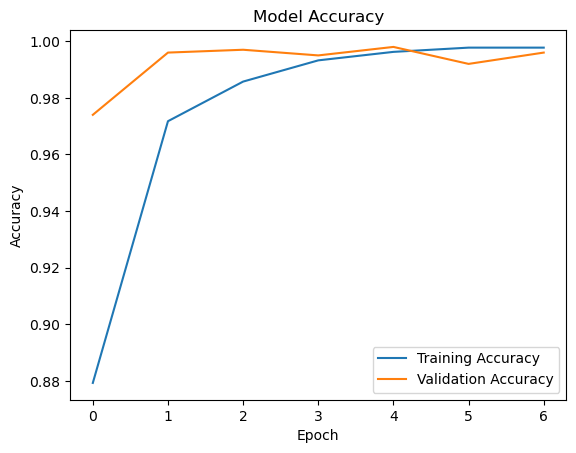

In [13]:
# Assuming 'model2.history' contains the history callback from your training process
plt.plot(model2.history.history['accuracy'], label='Training Accuracy')
plt.plot(model2.history.history['val_accuracy'], label='Validation Accuracy')

plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')

plt.show()


In [14]:
from keras.applications.inception_v3 import InceptionV3
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D

# create the base pre-trained model
base_model = InceptionV3(weights='imagenet', include_top=False)

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)
# and a logistic layer -- let's say we have 200 classes
predictions = Dense(4, activation='softmax')(x)

# this is the model we will train
model3 = Model(inputs=base_model.input, outputs=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
model3.compile(optimizer='rmsprop', loss='categorical_crossentropy',metrics=['accuracy',keras.metrics.Precision(), keras.metrics.Recall()])

# train the model on the new data for a few epochs
model3.fit(training_set,validation_data=test_set,epochs=7)

# at this point, the top layers are well trained and we can start fine-tuning
# convolutional layers from inception V3. We will freeze the bottom N layers
# and train the remaining top layers.

# let's visualize layer names and layer indices to see how many layers
# we should freeze:
for i, layer in enumerate(base_model.layers):
   print(i, layer.name)

# we chose to train the top 2 inception blocks, i.e. we will freeze
# the first 249 layers and unfreeze the rest:
for layer in model3.layers[:249]:
   layer.trainable = False
for layer in model3.layers[249:]:
   layer.trainable = True

# we need to recompile the model for these modifications to take effect
# we use SGD with a low learning rate
from keras.optimizers import SGD
model3.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy',metrics=['accuracy',keras.metrics.Precision(), keras.metrics.Recall()])

# we train our model again (this time fine-tuning the top 2 inception blocks
# alongside the top Dense layers
model3.fit(training_set,validation_data=test_set,epochs=7)

87910968/87910968 [==============================] - 10s 0us/step
Epoch 1/7
125/125 [==============================] - 90s 701ms/step - loss: 0.5842 - accuracy: 0.9158 - precision_1: 0.9218 - recall_1: 0.9103 - val_loss: 0.0352 - val_accuracy: 0.9900 - val_precision_1: 0.9900 - val_recall_1: 0.9900
Epoch 2/7
125/125 [==============================] - 91s 728ms/step - loss: 0.1005 - accuracy: 0.9758 - precision_1: 0.9760 - recall_1: 0.9755 - val_loss: 0.0182 - val_accuracy: 0.9940 - val_precision_1: 0.9940 - val_recall_1: 0.9930
Epoch 3/7
125/125 [==============================] - 92s 732ms/step - loss: 0.0433 - accuracy: 0.9883 - precision_1: 0.9887 - recall_1: 0.9880 - val_loss: 0.0082 - val_accuracy: 0.9970 - val_precision_1: 0.9970 - val_recall_1: 0.9960
Epoch 4/7
125/125 [==============================] - 95s 759ms/step - loss: 0.0353 - accuracy: 0.9910 - precision_1: 0.9910 - recall_1: 0.9905 - val_loss: 0.0063 - val_accuracy: 0.9980 - val_precision_1: 0.9980 - val_recall_1: 0.998

0 input_2
1 conv2d_2
2 batch_normalization
3 activation
4 conv2d_3
5 batch_normalization_1
6 activation_1
7 conv2d_4
8 batch_normalization_2
9 activation_2
10 max_pooling2d_2
11 conv2d_5
12 batch_normalization_3
13 activation_3
14 conv2d_6
15 batch_normalization_4
16 activation_4
17 max_pooling2d_3
18 conv2d_10
19 batch_normalization_8
20 activation_8
21 conv2d_8
22 conv2d_11
23 batch_normalization_6
24 batch_normalization_9
25 activation_6
26 activation_9
27 average_pooling2d
28 conv2d_7
29 conv2d_9
30 conv2d_12
31 conv2d_13
32 batch_normalization_5
33 batch_normalization_7
34 batch_normalization_10
35 batch_normalization_11
36 activation_5
37 activation_7
38 activation_10
39 activation_11
40 mixed0
41 conv2d_17
42 batch_normalization_15
43 activation_15
44 conv2d_15
45 conv2d_18
46 batch_normalization_13
47 batch_normalization_16
48 activation_13
49 activation_16
50 average_pooling2d_1
51 conv2d_14
52 conv2d_16
53 conv2d_19
54 conv2d_20
55 batch_normalization_12
56 batch_normalizatio

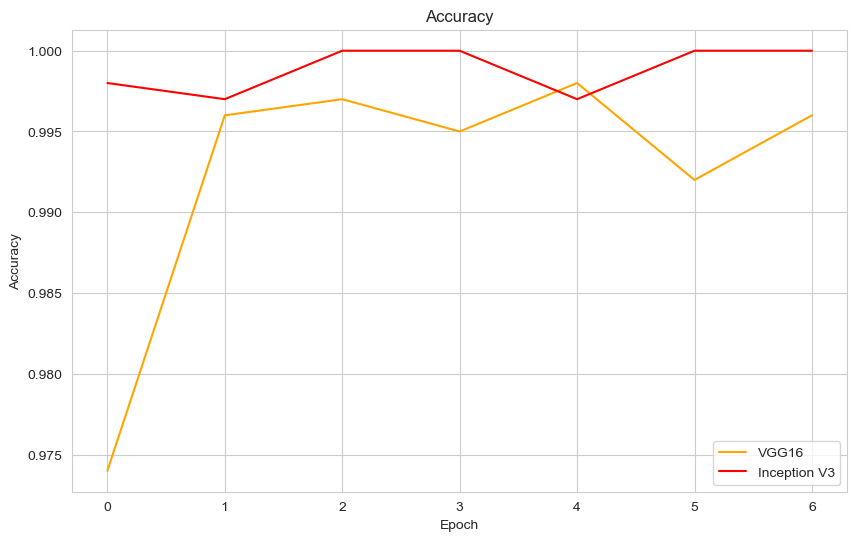

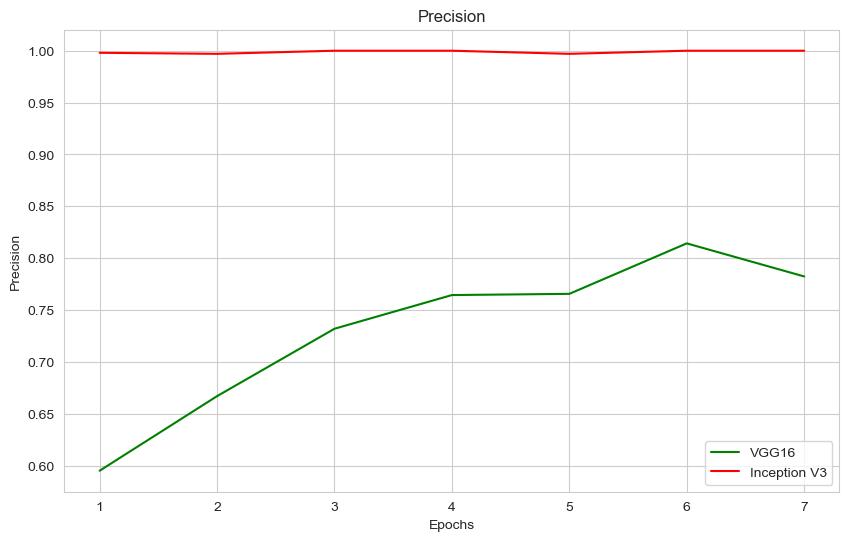

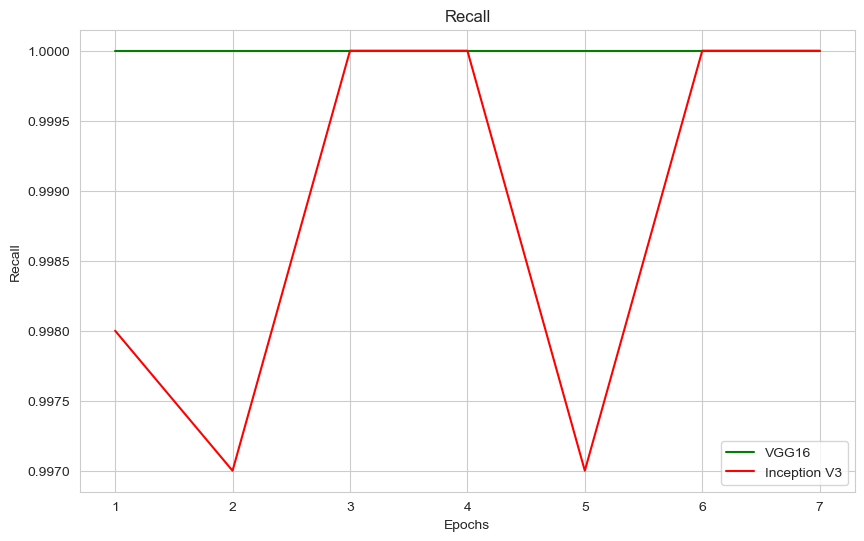

In [46]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set Seaborn style
sns.set_style("whitegrid")

# Plot Training and Validation Accuracy
plt.figure(figsize=(10, 6))
#plt.plot(model.history.history['val_accuracy'], label='Regular CNN', color='blue')
plt.plot(model2.history.history['val_accuracy'], label='VGG16', color='orange')
plt.plot(model3.history.history['val_accuracy'], label='Inception V3', color='red')

plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

# Plot Precision and Validation Precision
plt.figure(figsize=(10, 6))
plt.plot(epochs, model2.history.history['val_precision'], label='VGG16', color='green')
plt.plot(epochs, model3.history.history['val_precision_2'], label='Inception V3', color='red')

plt.title('Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()
plt.grid(True)
plt.show()

# Plot Recall and Validation Recall
plt.figure(figsize=(10, 6))
plt.plot(epochs, model2.history.history['val_recall'], label='VGG16', color='green')
plt.plot(epochs, model3.history.history['val_recall_2'], label='Inception V3', color='red')

plt.title('Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()
plt.grid(True)
plt.show()


In [47]:
model3.save('inceptionv3')

INFO:tensorflow:Assets written to: inceptionv3\assets


INFO:tensorflow:Assets written to: inceptionv3\assets


In [48]:
import pickle

with open('inceptionv3_model.pkl', 'wb') as f:
    pickle.dump(model3,f)

In [11]:
class_labels = list(test_set.class_indices.keys())  
class_labels

['black_spot_defect', 'bruise_defect', 'fresh', 'rot_defect']

In [1]:
import pickle
with open('inceptionv3_model.pkl' ,'rb') as f1:
    inception_model = pickle.load(f1)

C:\Users\jalad\anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
import numpy as np
from keras.applications.inception_v3 import preprocess_input, decode_predictions
from keras.preprocessing import image

# Load your custom test image
test_image_path = "C:\\Users\\jalad\\Downloads\\Healthy-Defective-Fruits-main\\Healthy-Defective-Fruits-main\\mango_images\\mango_synthethic_images\\bruise_defect\\G_SINT_0732.png"  # Replace with the actual path to your image
test_image = image.load_img(test_image_path, target_size=(224, 224))
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis=0)
test_image = preprocess_input(test_image)

# Get predictions (class probabilities)
predictions = inception_model.predict(test_image)

# Print the probabilities for each class
for prob in predictions[0]:
    print(f"Probability: {prob:.4f}")

1/1 [==============================] - 0s 89ms/step
Probability: 0.0022
Probability: 0.7204
Probability: 0.2310
Probability: 0.0464


In [3]:
# Define your own class names and indices
class_names = {2: "Fresh", 1: "Bruise", 0: "Black Spot", 3: "Rotten"}
# Print the top predictions
for i in range(len(predictions[0])):
    print(f"{class_names[i]}: {predictions[0][i]:.4f}")

Black Spot: 0.0022
Bruise: 0.7204
Fresh: 0.2310
Rotten: 0.0464
